# Stage 3: Counterfactual prediction

In this tutorial, we will walk through how to use the CASCADE model trained
in [stage 2](training.ipynb) to conduct counterfactual inference.

In [1]:
import anndata as ad
import networkx as nx
import numpy as np
import scanpy as sc
import seaborn as sns

from cascade.data import configure_dataset, encode_regime, get_configuration
from cascade.graph import annotate_explanation, core_explanation_graph, prep_cytoscape
from cascade.model import CASCADE
from cascade.plot import set_figure_params

In [2]:
set_figure_params()

## Read data and model

In [3]:
adata = sc.read_h5ad("adata.h5ad")

In [4]:
cascade = CASCADE.load("tune.pt")

In [5]:
scaffold = nx.read_gml("scaffold.gml.gz")
graph = nx.read_gml("discover.gml.gz")

## Specify counterfactual condition

Suppose we want to predict the counterfactual effect of triple gene perturbation
`"CEBPB,KLF1,MAPK1"` for the negative control cells, we'll need to first extract
some control cells, and then specify the perturbation in a column in `adata.obs`
(e.g., `"my_pert"`), in the same comma-separated format as the `"knockup"` column:

In [6]:
ctrl = adata[adata.obs["knockup"] == ""]
sc.pp.subsample(ctrl, n_obs=1000)
ctrl.obs["my_pert"] = "CEBPB,KLF1,MAPK1"

Then we call [encode_regime](api/cascade.data.encode_regime.rst) again to
encode this counterfactual perturbation into a binary regime matrix,
here in a new layer called `"ctfact"`:

In [7]:
encode_regime(ctrl, "ctfact", key="my_pert")

We'd also need to call [configure_dataset](api/cascade.data.configure_dataset.rst)
again to let the model use this new regime:

In [8]:
configure_dataset(ctrl, use_regime="ctfact")
get_configuration(ctrl)

22:30:46.858 | WARNING  | 1633490:data:configure_dataset - Overwriting existing `regime` = "interv".


{'covariate': 'covariate',
 'layer': 'counts',
 'regime': 'ctfact',
 'size': 'ncounts'}

## Run counterfactual prediction

Now we use the `counterfactual` method to perform counterfactual prediction
with this newly specified perturbation:

In [9]:
ctfact = cascade.counterfactual(ctrl, sample=True)

22:30:46.885 | INFO     | 1633490:utils:autodevice - Using GPU [3] as computation device.
22:30:47.051 | INFO     | 1633490:core:predict_mode - Number of topological generations: [68, 88, 70, 101]


Predicting: |                                                                                                 …

Here we specified `sample=True` to make the model output random samples from the
counterfactual negative binomial distribution, which would better represent
the distribution than a simple mean.

The prediction will be saved in both `ctfact.X` and `ctfact.layers["X_ctfact"]`,
where `ctfact.X` is the average prediction across SVGD particles, and
`ctfact.layers["X_ctfact"]` contains the per-particle predictions with shape
`(n_obs, n_vars, n_particles)`. Note that both of these are in raw count scale.

In [10]:
ctfact.X

array([[  0.  ,   6.5 ,  16.5 , ...,   0.  ,   0.  ,  72.25],
       [  1.  ,  10.5 ,  23.25, ...,   0.  ,   0.  , 140.  ],
       [  0.  ,  11.75,  32.75, ...,   0.  ,   0.  , 157.5 ],
       ...,
       [  0.25,   6.  ,  19.5 , ...,   0.  ,   0.  ,  59.25],
       [  0.25,   9.  ,  19.5 , ...,   0.  ,   0.  ,  90.75],
       [  0.5 ,   4.5 ,  18.  , ...,   0.  ,   0.  ,  77.25]],
      dtype=float32)

In [11]:
ctfact.layers["X_ctfact"].shape

(1000, 1064, 4)

> For counterfactual prediction of [CASCADE designs](design.ipynb), you would
> also need to specify the `design` argument to the `counterfactual` method.

Please visit the documentation of
[counterfactual](api/cascade.model.CASCADE.counterfactual.rst)
for more details.

The same can also be achieved using the
[command line interface](cli.rst#counterfactual-deduction),
with the following command:

```sh
cascade counterfactual -d ctrl.h5ad -m tune.pt -p ctfact.h5ad [other options]
```

## Counterfactual differential expression comparison

To check for counterfactual effects, we are expected to compare the predicted
dataset (`ctfact`) with the input dataset (`ctrl`). However, to avoid artifacts
caused by model prediction biases, it is recommended to compare the predicted
dataset (`ctfact`) with a "nil prediction", i.e., model prediction with the
original perturbation labels.

Here, we can go back to use the `"interv"` regime to obtain the "nil prediction":

In [12]:
configure_dataset(ctrl, use_regime="interv")
get_configuration(ctrl)

22:30:49.596 | WARNING  | 1633490:data:configure_dataset - Overwriting existing `regime` = "ctfact".


{'covariate': 'covariate',
 'layer': 'counts',
 'regime': 'interv',
 'size': 'ncounts'}

In [13]:
nil = cascade.counterfactual(ctrl, sample=True)

22:30:49.790 | INFO     | 1633490:core:predict_mode - Number of topological generations: [68, 88, 70, 101]


Predicting: |                                                                                                 …

Now we combine and log-normalize both predictions to perform differential
expression analysis:

In [14]:
combined = ad.concat({"nil": nil, "ctfact": ctfact}, label="role", index_unique="-")
combined.X = np.log1p(combined.X * (1e4 / combined.obs[["ncounts"]].to_numpy()))
combined

AnnData object with n_obs × n_vars = 2000 × 1064
    obs: 'guide_id', 'gemgroup', 'ncounts', 'knockup', 'my_pert', 'role'
    obsm: 'X_pca', 'covariate'
    layers: 'counts', 'interv', 'ctfact', 'X_ctfact'

In [15]:
sc.tl.rank_genes_groups(combined, "role", reference="nil", rankby_abs=True, pts=True)
de_df = sc.get.rank_genes_groups_df(combined, "ctfact").query("pct_nz_group > 0.05")
de_df["-logfdr"] = -np.log10(de_df["pvals_adj"]).clip(lower=-350)
de_df.head()

/rd1/user/caozj/CASCADE/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,-logfdr
0,KLF1,207.035004,1.951955,0.0,0.0,1.0,350.0
1,PNMT,171.383087,2.364175,0.0,0.0,1.0,350.0
2,CEBPB,152.714493,2.131128,0.0,0.0,1.0,350.0
3,TMSB10,144.004883,1.232379,0.0,0.0,1.0,350.0
4,MAPK1,134.214584,1.047204,0.0,0.0,1.0,350.0


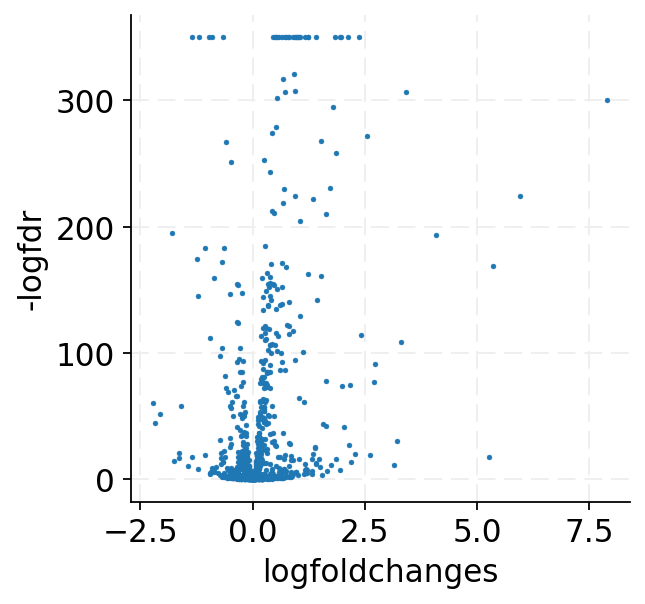

In [16]:
ax = sns.scatterplot(data=de_df, x="logfoldchanges", y="-logfdr", edgecolor=None, s=5)

## Explain counterfactual prediction

To understand why CASCADE made the above prediction, we can use the `explain`
method to decompose the contribution into individual components in the model.

The method needs both a factual dataset (`ctrl`) and a counterfactual
prediction (`ctfact`), properly configured as below:

In [17]:
configure_dataset(ctrl, use_regime="interv")
get_configuration(ctrl)

{'covariate': 'covariate',
 'layer': 'counts',
 'regime': 'interv',
 'size': 'ncounts'}

In [18]:
configure_dataset(ctfact, use_layer="X_ctfact")
get_configuration(ctfact)

22:30:52.161 | WARNING  | 1633490:data:configure_dataset - Overwriting existing `layer` = "counts".


{'covariate': 'covariate',
 'layer': 'X_ctfact',
 'regime': 'ctfact',
 'size': 'ncounts'}

In [19]:
explanation = cascade.explain(ctrl, ctfact)
explanation

Predicting: |                                                                                                 …

AnnData object with n_obs × n_vars = 1000 × 1064
    obs: 'guide_id', 'gemgroup', 'ncounts', 'knockup', 'my_pert'
    var: 'perturbed', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'selected'
    uns: '__CASCADE__', 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'covariate'
    varm: 'PCs'
    layers: 'counts', 'interv', 'ctfact', 'X_ctfact', 'X_nil', 'X_ctrb_i', 'X_ctrb_s', 'X_ctrb_z', 'X_ctrb_ptr', 'X_tot'

The explanation is also an `AnnData` dataset with predictions from individual
model components saved in separate layers.

We can pass this explanation dataset to the
[annotate_explanation](api/cascade.graph.annotate_explanation.rst) function
to annotate the contributions on graph nodes and edges:

In [20]:
explanation_graph = annotate_explanation(
    graph, explanation, cascade.export_causal_map()
)
explanation_graph.number_of_nodes(), explanation_graph.number_of_edges()

(1064, 12294)

Note that `annotate_explanation` has a `cutoff` argument (by default 0.2)
that you may want to adjust, which specifies an cutoff of predicted effect
(in log-normalized expression space), below which the effect is deemed too
small to explain.

We can then extract a core subgraph that explains expression changes for a
specific list of genes (e.g., top 10 genes with the most prominent changes),
using the [core_explanation_graph](api/cascade.graph.core_explanation_graph.rst)
function:

In [21]:
response = de_df["names"].head(20).to_list()
response

['KLF1',
 'PNMT',
 'CEBPB',
 'TMSB10',
 'MAPK1',
 'S100A11',
 'ISG15',
 'SH3BGRL3',
 'FCER1G',
 'S100A10',
 'GMFG',
 'IL2RG',
 'PIM1',
 'NPW',
 'BLVRB',
 'ACTB',
 'EMP3',
 'NTRK1',
 'LGALS1',
 'RELN']

In [22]:
core_subgraph = core_explanation_graph(explanation_graph, response)
core_subgraph.number_of_nodes(), core_subgraph.number_of_edges()

(50, 107)

This core subgraph can be exported to [Cytoscape](https://cytoscape.org/)
for visualization using the utility function
[prep_cytoscape](api/cascade.graph.prep_cytoscape.rst):

In [23]:
nx.write_gml(
    prep_cytoscape(core_subgraph, scaffold, ["CEBPB", "KLF1", "MAPK1"], response),
    "cytoscape.gml",
)

You may download a template Cytoscape file containing corresponding styles from:

- http://ftp.cbi.pku.edu.cn/pub/cascade-download/template.cys

Click here to apply style:

![style](style.png)

Below is an example visualization of the above core explanation graph:

![cytoscape](cytoscape.png)